# High voltage calibration example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import farid, sobel, scharr, prewitt, roberts
from pyextal.dinfo import LARBEDDiffractionInfo
from pyextal.roi import LARBEDROI

from pyextal.optimize import CoarseOptimize, FineOptimize
from pyextal.gof import Chi2, Chi2_const

# set the plotting colormap
plt.rcParams['image.cmap'] = 'inferno'


pyextal package imported. Version: 0.0.1


### load data
load the off zone axis LARBED data



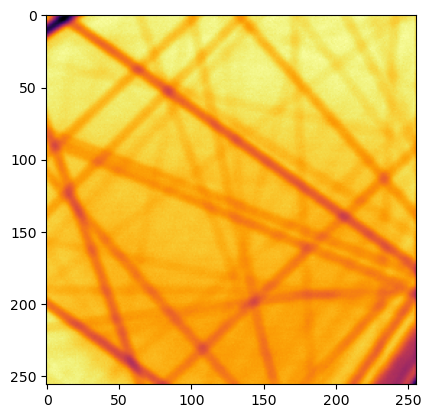

In [2]:
data = np.load("box/20250420/111-002 holz area1/raw_stack_ri4.npy")
data = np.flip(data,axis=2)
variance = np.load("box/20250420/111-002 holz area1/deconv3_ri3_subpixel_realconvstd2.npy")
gindex = np.load("box/20250420/111-002 holz area1/deconv3_ri3_subpixel_realconv_g_vectors.npy")
# dp = data[0]


plt.imshow(data[21])

### initialize diffraction info class
- data: LARBED intensity
- thickness
- tiltx
- tilty
- gl
- .dat file
- gindex for LARBED
- variance: actually not needed here, but required for the class


In [3]:
dinfo = LARBEDDiffractionInfo(data,  1100,  0, 0, 63.646, 'si110_111_002holz.dat', gindex, varianceMaps=variance)


### region of interest parameters:
defines the region of interest for refinement
- rotation: relative to the xaxis set in .dat
- gInclude: g vector to include in the refinement
- gx: horizontal g vector

In [4]:

rotation = -112.07 +1.66
gInclude = [(0,0,0), (1,-1,-1),(-1,1,1)]
gx = np.array([2,-2,0])

In [5]:
roi = LARBEDROI(dinfo=dinfo, rotation=rotation, gx=gx, gInclude=gInclude) 


include beam initialized
group symmetry initialized


### specify the region of interest

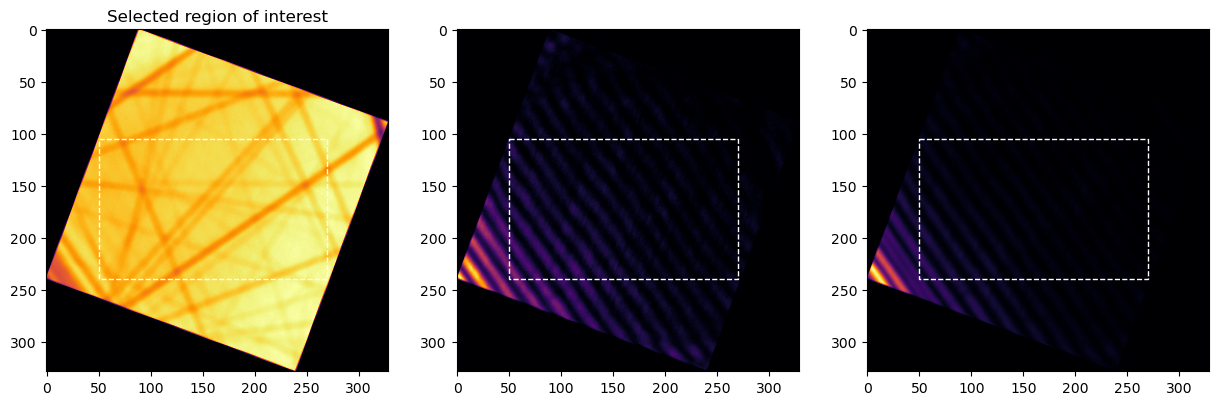

In [6]:
roi.selectROI(np.array([[[105,50], [105, 270], [240,50], [150,150]]]))
roi.displayROI()

### initialize coarse refine
- only support rectangular ROI, and only one region for coarse refine

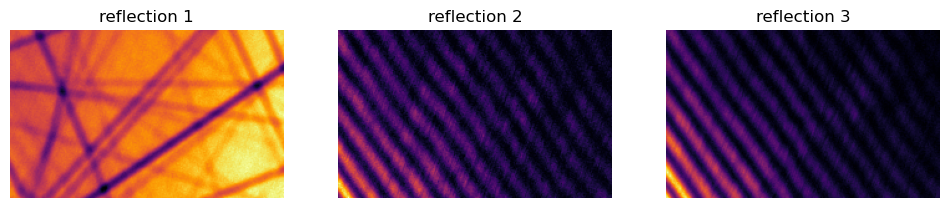

In [7]:
coarse = CoarseOptimize(dinfo=dinfo, roi=roi)

### define a customize image filtering function for coarse refinement
function signature:
```python
def filter_func(image, sim=False):
    """
    :param image: 2D numpy array
    :param sim: if True, the image is a simulated image, otherwise it is experimental
    :return: 2D numpy array
    """
```
Since experimental data and simulated data have very different ranges, it might be desirable to have different filtering for them. This is supported by the `sim` parameter.

In [8]:
from skimage.filters import meijering

def meij_filter(data, sim=False):
    return meijering(data, sigmas=range(2, 4), black_ridges=True)


In [9]:
coarse.optimizeOrientationThickness(filter=meij_filter)



Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 1129.580194918737, gl: 63.646, tiltY: -0.31703060406687156, tiltX: 0.5191950472399494


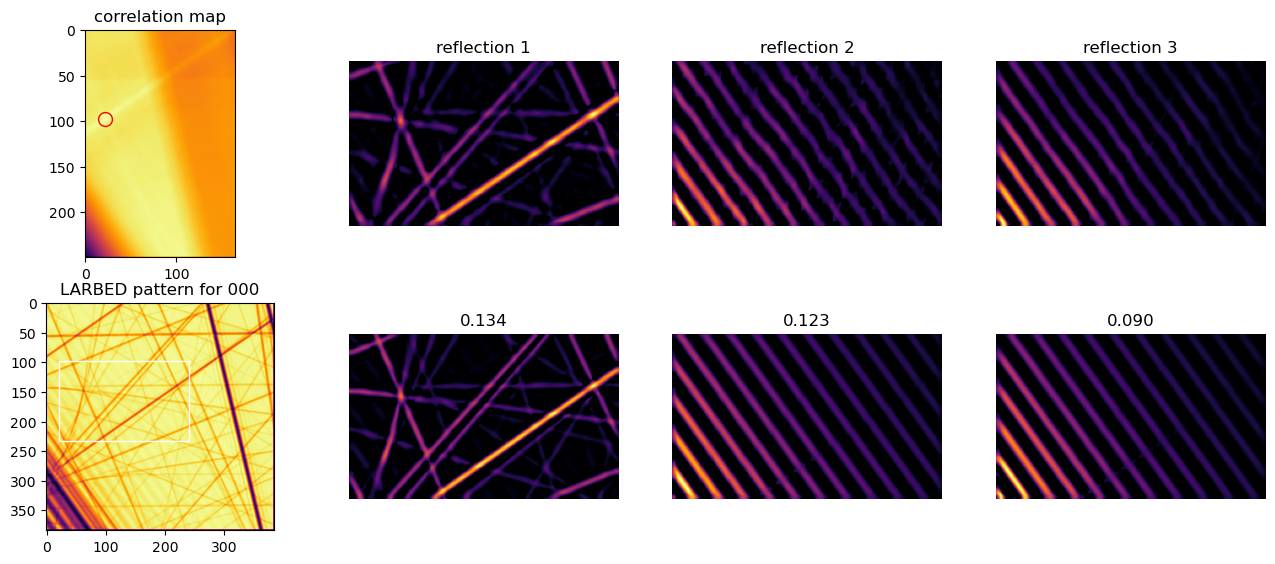

In [10]:
coarse.displayCoarseSearch(filter=meij_filter)

### redefine ROI and coarse refine
- here we only want to keep the bright field pattern for refining high voltage, as we already refined the thickness, so the dark-field rocking curve spacing is not needed

include beam initialized
group symmetry initialized


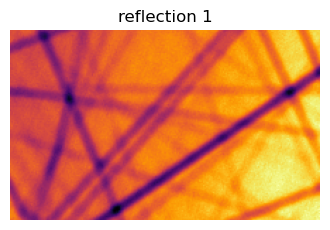

In [11]:
roi = LARBEDROI(dinfo=dinfo, rotation=rotation, gx=np.array([2,-2,0]), gInclude=[(0,0,0),]) 
roi.selectROI(np.array([[[105,50], [105, 270], [240,50], [150,150]]]))

coarse = CoarseOptimize(dinfo=dinfo, roi=roi)

In [12]:
coarse.optimizeOrientationGL(filter=meij_filter)


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 1129.580194918737, gl: 63.50489040498052, tiltY: -0.31703060406687156, tiltX: 0.5191950472399494


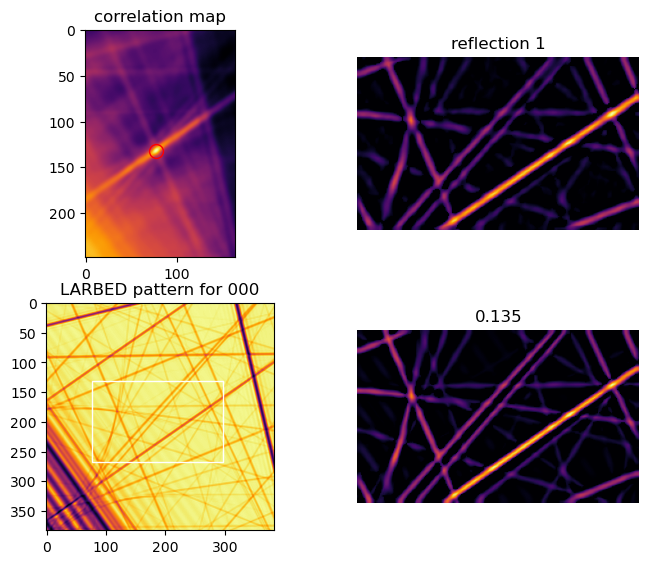

In [13]:
coarse.displayCoarseSearch(filter=meij_filter)

### optimize high voltage

In [14]:
coarse.optimzeHV(filter=meij_filter)

HV: 300.56040649414064kV
correlation: 0.19798288940777709
HV: 300.9604064941406kV
correlation: 0.16808618462773484
HV: 301.6076200941406kV
correlation: 0.3699509259463487
HV: 301.2076200840782kV
correlation: 0.21365249066045977
HV: 300.80762009414065kV
correlation: 0.1642921776118692
HV: 300.8528734232853kV
correlation: 0.16343406286675322
HV: 300.85588195202956kV
correlation: 0.1634176254043087
HV: 300.86414461674855kV
correlation: 0.16349430039872093
HV: 300.8590380090216kV
correlation: 0.1634385765381372

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 1e-05 )
final HV: 300.85588195202956

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 1129.580194918737, gl: 63.289405762452965, tiltY: -0.3216493693815512, tiltX: 0.5145762819252697


### we can plot out the error surface

In [ ]:

kv = np.linspace(300.2,301.2,100)
template_match = []
for v in kv:
    template_match.append(coarse.HVTarget(v, coarse))
coarse.HVTarget(kv[np.argmin(template_match)], coarse)

HV: 300.2kV
correlation: 0.3580068969154303
HV: 300.21010101010097kV
correlation: 0.35349265483177994
HV: 300.220202020202kV
correlation: 0.34872787302382735
HV: 300.230303030303kV
correlation: 0.3442719935592098
HV: 300.24040404040403kV
correlation: 0.3398057559353532
HV: 300.250505050505kV
correlation: 0.3352727168210642
HV: 300.26060606060605kV
correlation: 0.33080303862331384
HV: 300.27070707070703kV
correlation: 0.3262885313090841
HV: 300.2808080808081kV
correlation: 0.3219769806676619
HV: 300.29090909090905kV
correlation: 0.3177224010408827
HV: 300.3010101010101kV
correlation: 0.31349837466019836
HV: 300.3111111111111kV
correlation: 0.3092920059033637
HV: 300.3212121212121kV
correlation: 0.30517852857527716
HV: 300.3313131313131kV
correlation: 0.3010602062300114
HV: 300.34141414141413kV
correlation: 0.297066364223743
HV: 300.3515151515151kV
correlation: 0.29308107008245465
HV: 300.36161616161615kV
correlation: 0.28929369269162464
HV: 300.37171717171714kV
correlation: 0.2852202346

0.17722039985152516

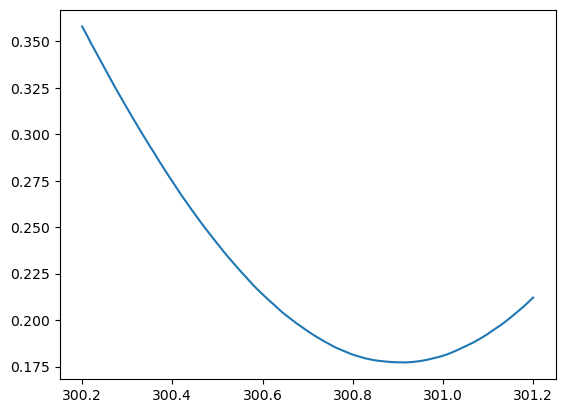

In [17]:
plt.plot(kv, template_match)